In [1]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import delensalot
from delensalot.run import run
from delensalot import utils as dutils
from delensalot.utility.plot_helper import bandpass_alms, movavg
from delensalot.utility.utils_hp import alm_copy, almxfl

planck_cmap = ListedColormap(np.loadtxt(os.path.dirname(delensalot.__file__)+"/data/Planck_Parchment_RGB.txt")/255.)
planck_cmap.set_bad("gray")
planck_cmap.set_under("white") 

fn = opj('/mnt/home/sbelkner/git/pySHT/test/lensing_reconstruction/', 'conf_mwe_fullsky.py')

mpisupport: True, pmisupport: False
disabling mpi
[SHTns 3.6.1] built Feb 15 2024, 12:12:28, id: v3.6.1-41-g3d56397*,avx2,ishioka,openmp
Using lenspyx alm2map


# Simulation generation

In [2]:
delensalot_runner = run(config_fn=fn, job_id='generate_sim', verbose=True) # QE_lensrec
delensalot_runner.run()
ana_mwe = delensalot_runner.collect_model()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

INFO:: 02-27 10:19:56:: delensalot.config.handler.store - /mnt/home/sbelkner/git/pySHT/test/lensing_reconstruction/conf_mwe_fullsky.py


TypeError: DLENSALOT_Simulation.__init__() got an unexpected keyword argument 'solver'

How do you know that it worked? Let's print the power spectra of the simulations

In [12]:
CMB_obslm = ana_mwe.simulationdata.get_sim_obs(space='alm', field='polarization', spin=0, simidx=0)
CMB_lenlm = ana_mwe.simulationdata.get_sim_sky(space='alm', field='polarization', spin=0, simidx=0)

plm_in = ana_mwe.simulationdata.get_sim_phi(0, space='alm')

INFO:: 08-11 12:40:50:: delensalot.sims.sims_lib.get_sim_obs - requesting "obs_spacealm_spin0_fieldpolarization_0"
INFO:: 08-11 12:40:50:: delensalot.sims.sims_lib.get_sim_obs - ..nothing cached..
INFO:: 08-11 12:40:50:: delensalot.sims.sims_lib.get_sim_obs - .., but stored on disk.
INFO:: 08-11 12:40:51:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldpolarization_0"
INFO:: 08-11 12:40:51:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 08-11 12:40:51:: delensalot.sims.sims_lib.get_sim_sky - .., but stored on disk.


(0.0001, 100.0)

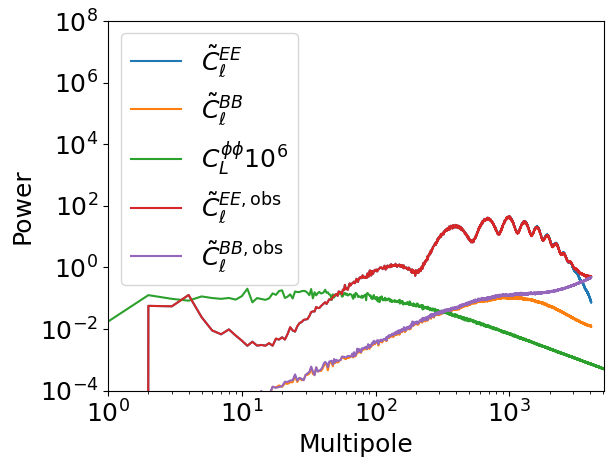

In [4]:
ll = np.arange(0,ana_mwe.simulationdata.lmax+1,1)
LL = np.arange(0,ana_mwe.simulationdata.phi_lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/(2*np.pi)*1e6

plt.plot(scale_factor_l*hp.alm2cl(CMB_lenlm[0]), label=r'$\tilde{C}_\ell^{EE}$')
plt.plot(scale_factor_l*hp.alm2cl(CMB_lenlm[1]), label=r'$\tilde{C}_\ell^{BB}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_in), label=r'$C_L^{\phi\phi} 10^6$')

plt.plot(scale_factor_l*hp.alm2cl(CMB_obslm[0]), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l*hp.alm2cl(CMB_obslm[1]), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.xlabel('Multipole')
plt.ylabel('Power')
plt.xlim(1e0,len(LL))
plt.loglog()
plt.legend()
plt.ylim(1e-4,1e2)

# QE lensing reconstruction
The following cell,
 
 * line 1: initialises delensalot for a QE lensing reconstruction job (`job_id`) and the [configuration file](./conf_mwe_fullsky.py),
 * line 2: perfroms lensing reconstruction and calculates both, the lensing potential, and the $B$-lensing template.

In [2]:
delensalot_runner = run(config_fn=fn, job_id='QE_lensrec', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.collect_model()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 12:43:29


# Iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The number of iterations is defined in `DLENSALOT_Itrec.itmax`.

Line 3, in addition, provides the job-object, so that all data and objects can be accessed.

In [8]:
delensalot_runner = run(config_fn=fn, job_id='MAP_lensrec', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.collect_model()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 08:13:44


# Check your results
## lensing potential
After completion of above cells, you may want to see the reconstructed lensing potential for both the QE and iterative method.

 * `get_plm_it(idx, its)` returns the spherical harmonics for simulation `idx` and iterations `its`, `its=0` is the QE estimate.

In [ ]:
LL = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor_L = (LL*(LL+1))**2/(2*np.pi)

plm_QE = ana_mwe.get_plm_it(ana_mwe.simidxs[0], [0])[0]
plm_MAP = ana_mwe.get_plm_it(ana_mwe.simidxs[0], [ana_mwe.itmax])[0]
plm_in = alm_copy(ana_mwe.simulationdata.get_sim_phi(0, space='alm'), None, *ana_mwe.lm_max_qlm)

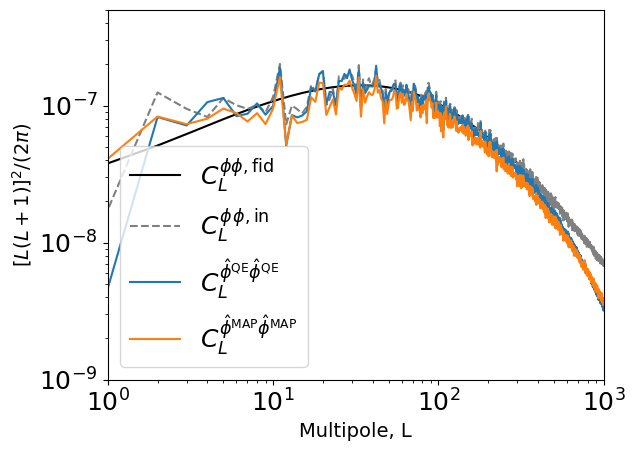

In [9]:
plt.plot(scale_factor_L*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$', color='black')
plt.plot(scale_factor_L*hp.alm2cl(plm_in), label=r'$C_L^{\phi^{\rm}\phi,{\rm in}}$', color='grey', ls='--')
plt.plot(scale_factor_L*hp.alm2cl(plm_QE), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_MAP), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.legend(fontsize=18, loc='lower left', ncol=2)
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-7)
plt.yscale('log')

The difference to the input lensing potential $C_L^{\phi\phi, \rm{in}}$, in particular at high L, is due to the reconstruction noise and normalization of the estimates, which have not yet been taken care of in this plot. You will do this later.

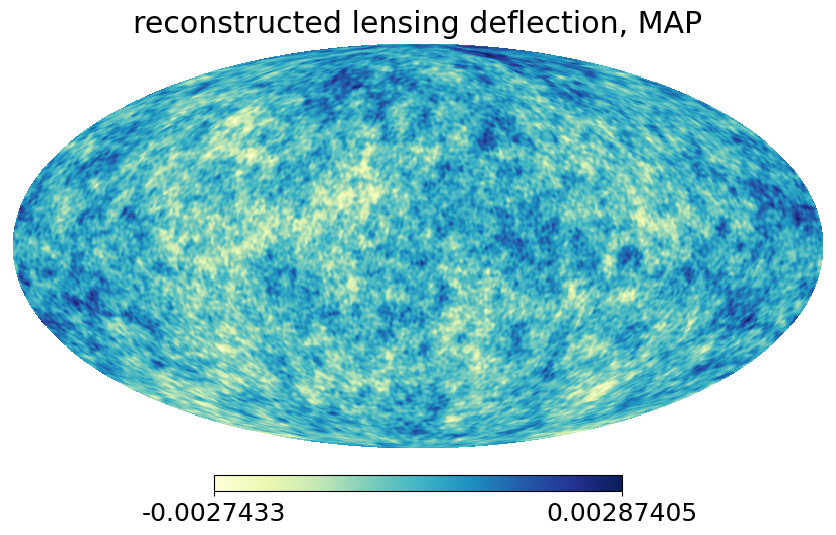

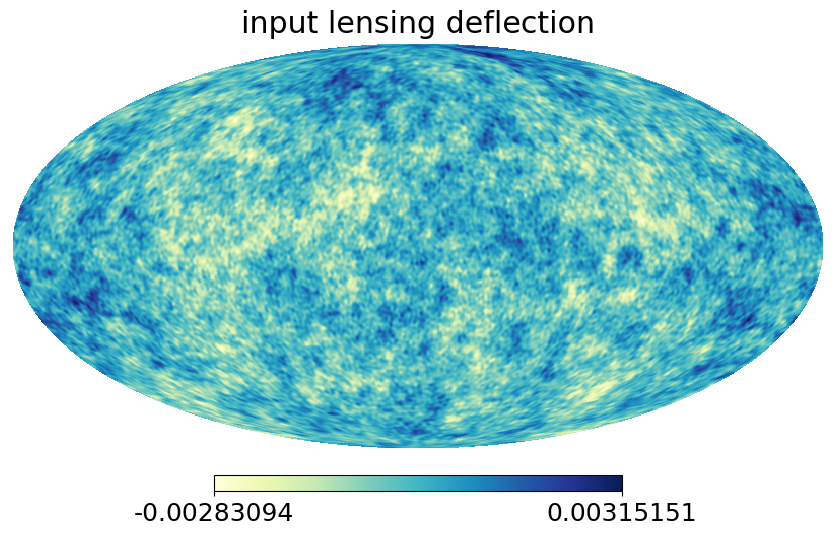

In [10]:
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(plm_MAP,np.sqrt(ll*(ll+1))),1,200), nside=256), title='reconstructed lensing deflection, MAP', cmap='YlGnBu')
hp.mollview(hp.alm2map(bandpass_alms(hp.almxfl(plm_in,np.sqrt(ll*(ll+1))),1,200), nside=256), title='input lensing deflection', cmap='YlGnBu')

# Delensing
For both QE and iterative lensing reconstruction, delensalot calculated the $B$-lensing templates in the above cells. You can use them to delens the $B$-lensing maps and obtain residual maps.

Due to this tutorial being full sky, all actions in this section could simply be done by using a full sky power spectrum calculator such as healpy.
However, for the sake of this tutorial, you will be using `delensalot`'s power spectrum calculation, and mask the data for which the power spectra will be calculated

Hence, in the next cell, you create a mask and store at the path given by `mask_fn` in the next cell. This path must match the `DLENSALOT_Model.MAP_Delensing.rhits_normalised` attribute of the configuration file.

fsky: 0.083
mask stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/my_first_dlensalot_analysis_fullsky_lminB200


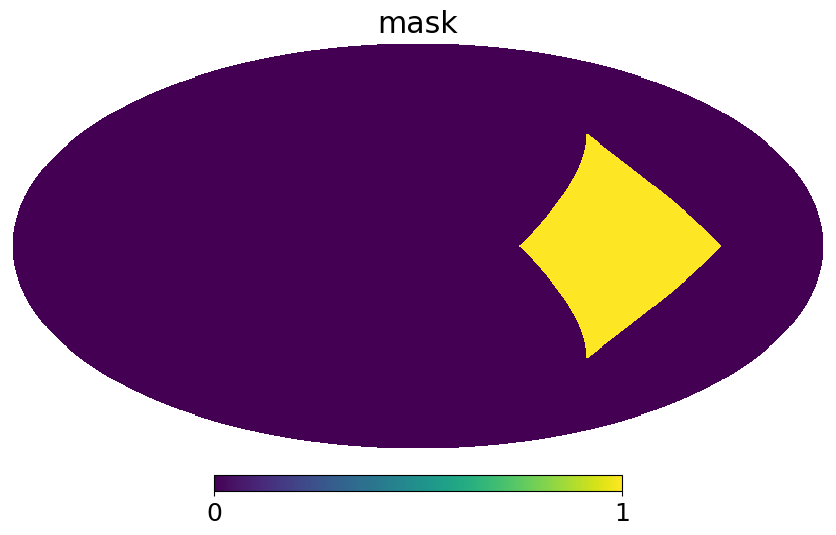

In [11]:
m = np.zeros(hp.nside2npix(1))
m[[7]] = 1
mask = hp.ud_grade(m, nside_out=2048)
hp.mollview(mask, title='mask')
print('fsky: {:.3f}'.format(np.mean(m)))

mask_fn = opj(os.environ["SCRATCH"], 'analysis', 'my_first_dlensalot_analysis_fullsky_lminB200', 'mask.fits')
# opj(ana_mwe.TEMP, 'mask.fits')
if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    print('mask stored at {}'.format(os.path.dirname(mask_fn)))
else:
    print('mask already exists at {}'.format(os.path.dirname(mask_fn)))

In [4]:
delensalot_runner = run(config_fn=fn, job_id='delens', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 13:34:18


After above cell is run, you can access the QE and MAP delensed $B$ SHTs via,
 * `get_residualblens(simidx, it)`.
If delensing and data was unmasked, `get_residualblens` will return unmasked SHTs. 

The fractional power spectra relative to the power spectrum template are accessed via,
 * `read_data()`

and returns an array of dimension `(2+nits,nlevels,nsimidxs,nedges)`. These are the result for the masked area. The,
 * first dimension is the pure B-lensing map, QE-delensed, and all MAP-delensed results,
 * second dimension is the masks derived from the nlevels attribute of the config file, and the `masks_fn` attribute. If no nlevels are given, it will calculate for np.inf, plus all the masks_fn, therefore we have `1 + len(masks_fn)` many power spectra there,
 * third dimension is the simulations,
 * fourth dimension is the individual edges.

In [5]:
Blensing_index, QEdel_index, MAPdel_index = 0, 1, 2
mask_index = 1

INFO:: 06-20 13:47:05:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldpolarization_0"
INFO:: 06-20 13:47:05:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldpolarization_0"
INFO:: 06-20 13:47:05:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldpolarization_0"


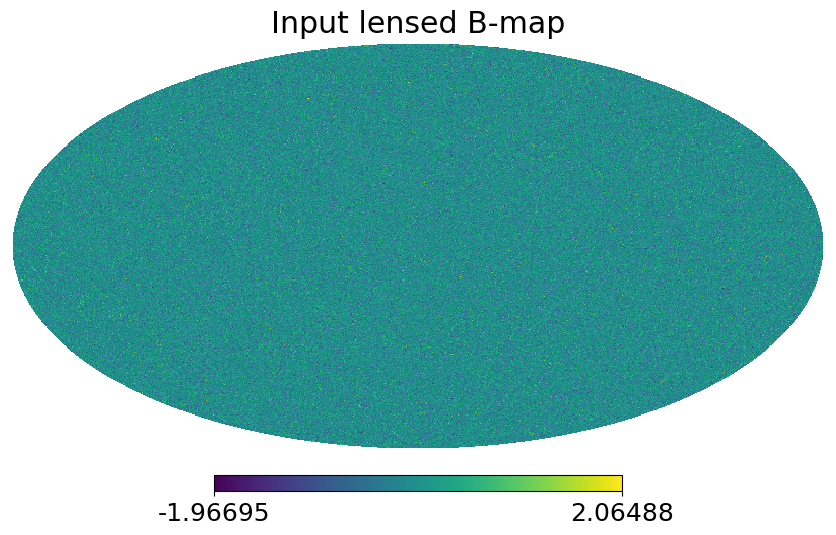

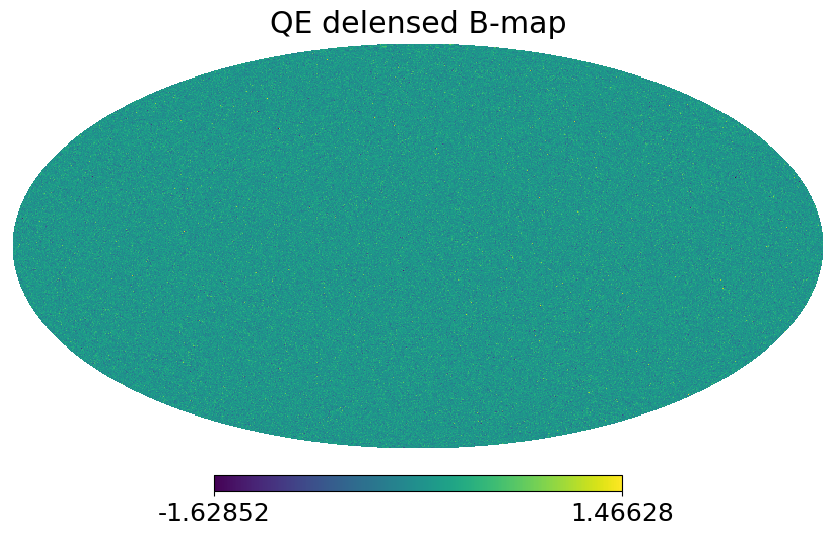

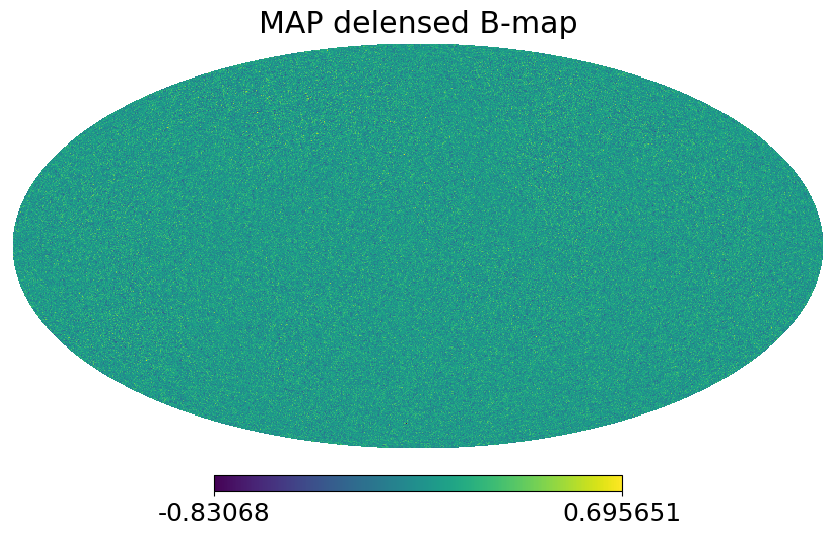

In [8]:
input_blensing = almxfl(alm_copy(ana_mwe.simulationdata.get_sim_sky(ana_mwe.simidxs[0], space='alm', spin=0, field='polarization')[1], None, *ana_mwe.lm_max_blt), ana_mwe.ttebl['e'], ana_mwe.lm_max_blt[0], inplace=False) 

blens_residual_QE = ana_mwe.get_residualblens(ana_mwe.simidxs[0], 0)
blens_residual_MAP = ana_mwe.get_residualblens(ana_mwe.simidxs[0], ana_mwe.its[-1])

clbb = ana_mwe.read_data()

hp.mollview(hp.alm2map(input_blensing, nside=256), title='Input lensed B-map')
hp.mollview(hp.alm2map(blens_residual_QE, nside=256), title='QE delensed B-map')
hp.mollview(hp.alm2map(blens_residual_MAP, nside=256), title='MAP delensed B-map')

To obtain the spectra, we multiply the fractional spectra by the power spectrum template `ct`.

The blue line is the input lensing potential. The QE and MAP estimates are shown in orange and green. We also show the binned power spectra. As expected, they match the full sky power spectrum, indicating that everything works as intended.

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

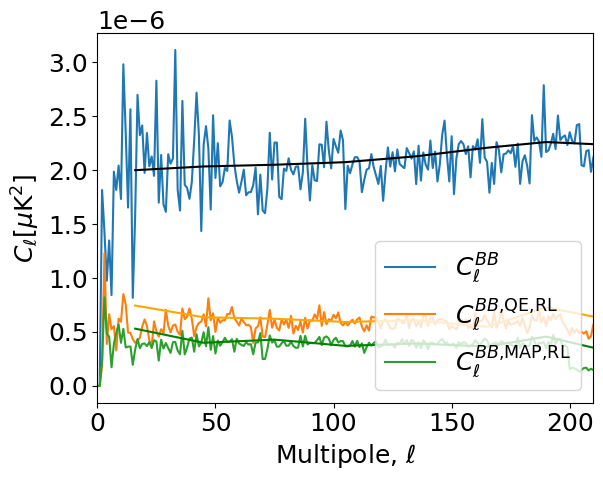

In [9]:
plt.plot(hp.alm2cl(input_blensing, lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax=ana_mwe.lm_max_blt[0], lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB{,}{\rm QE{,}RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax=ana_mwe.lm_max_blt[0], lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB{,}{\rm MAP{,}RL}}$')

plt.plot(ana_mwe.edges_center, ana_mwe.ct[1:], color='black')
plt.plot(ana_mwe.edges_center, clbb[QEdel_index,mask_index,ana_mwe.simidxs[0],:]*ana_mwe.ct[1:], color='orange')
plt.plot(ana_mwe.edges_center, clbb[MAPdel_index,mask_index,ana_mwe.simidxs[0],:]*ana_mwe.ct[1:], color='green')

plt.legend(loc='lower right')
plt.xlim(0,210)
# plt.ylim(1e-7,1e-5)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

Note that The MAP-delensed power spectrum isn't very much lower. This is due to the low number of iterations in this tutorial. Feel free to change the number in the configuration file (7-8 is a good number for this configuration) to convince yourself that the iterative approach can reduce the $B$-lensing signal even more. 

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual $B$-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak, $30<\ell<200$.

In [10]:
lmin, lmax = (30, 200)
Alens_QE = np.mean(hp.alm2cl(blens_residual_QE, lmax_out=lmax)[lmin:lmax])/np.mean(hp.alm2cl(input_blensing, lmax_out=lmax)[lmin:lmax])
Alens_MAP = np.mean(hp.alm2cl(blens_residual_MAP, lmax_out=lmax)[lmin:lmax])/np.mean(hp.alm2cl(input_blensing, lmax_out=lmax)[lmin:lmax])  
print(20*'~.')
print(':::Empiric:::')
print('nlev: {}, lmax_ivf: {}, beam: {} arcmin '.format(str(ana_mwe.nlev), ana_mwe.lm_max_ivf, ana_mwe.beam))
print("A_L^QE: {:.3f}, A_L^MAP: {:.3f}".format(Alens_QE, Alens_MAP))
print(20*'~.')

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
:::Empiric:::
nlev: {'P': 1.4142135623730951, 'T': 1.0}, lmax_ivf: (4000, 4000), beam: 1.0 arcmin 
A_L^QE: 0.284, A_L^MAP: 0.188
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.


# Normalization and Prediction
To properly compare the estimates to the input data and to make predictions, we need to normalize the estimates accordingly.
For QE, we calculate the response in the normal manner, for MAP, we calculate the Wiener-Filter inclusive of the noise biases $N^{(0)}_L$, $N^{(1)}_L$, which delensalot can handily predict.

We then use this to make a prediction for $A_L$.

In [11]:
from camb.correlations import lensed_cls
from plancklens import n0s, utils
from delensalot.biases import n0n1_iterative
from delensalot.core import cachers

dls_unl_true, cldd_true = dutils.cls2dls(ana_mwe.cls_unl)
llp2 = np.arange(ana_mwe.lm_max_qlm[0] + 1, dtype=float) ** 2 * np.arange(1, ana_mwe.lm_max_qlm[0] + 2, dtype=float) ** 2 / (2. * np.pi)
lmin_teb = dict({k:v for k,v in zip(['t', 'e', 'b'], ana_mwe.lmin_teb)})
Cl_del_MAP = n0s.get_N0_iter(
    qe_key='p_p',
    nlev_t=ana_mwe.nlev['T'],
    nlev_p=ana_mwe.nlev['P'],
    beam_fwhm=ana_mwe.beam,
    cls_unl_fid=ana_mwe.cls_unl,
    lmin_cmb=lmin_teb,
    lmax_cmb=ana_mwe.lm_max_ivf[0],
    itermax=ana_mwe.itmax,
    cls_unl_dat=None,
    lmax_qlm=ana_mwe.lm_max_qlm[0],
    ret_delcls=True)[-1][-1]['bb'][30:200]

def get_N0_N1_iter(itermax, version="wE"):
    N0N1_config = (ana_mwe.nlev['T'],ana_mwe.nlev['P'],ana_mwe.beam,ana_mwe.lmin_teb,ana_mwe.lm_max_ivf[0],ana_mwe.lm_max_qlm[0])
    cacher_param = cachers.cacher_npy(opj(ana_mwe.TEMP, "N0N1"))
    iterbiases = n0n1_iterative.polMAPbiases(
        N0N1_config, fidcls_unl=ana_mwe.cls_unl, itrmax=itermax, cacher=cacher_param)
    N0_biased, N1_biased, _, _ = iterbiases.get_n0n1(
        cls_unl_true=None, cls_noise_true=None, version=version)
    return N0_biased, N1_biased, _, _

def get_cl_plen(dls_unl_true, cldd_true, N0, N1, lmax_qlm):
    rho =  np.zeros(len(cldd_true))
    if N1 is None: N1 = np.zeros(len(cldd_true))
    rho[:lmax_qlm + 1] =  cldd_true[:lmax_qlm + 1] * utils.cli(cldd_true[:lmax_qlm + 1] + llp2 * (N0[:lmax_qlm+1] + N1[:lmax_qlm + 1]))
    cpp_del = cldd_true * (1 - rho)
    return dutils.dls2cls(lensed_cls(dls_unl_true, cpp_del))['bb']

N0_QE, N1_QE, _, _ = get_N0_N1_iter(0)
N0_MAP, N1_MAP, _, _ = get_N0_N1_iter(ana_mwe.itmax)

cl_del_QE = get_cl_plen(dls_unl_true, cldd_true, N0_QE, N1_QE, ana_mwe.lm_max_qlm[0])

Alens_QE_pred = np.mean((cl_del_QE[30:200]/ana_mwe.cls_len['bb'][30:200]))
Alens_MAP_pred = np.mean((Cl_del_MAP/ana_mwe.cls_len['bb'][30:200]))

Seeing lmin's:
t: 2
e: 2
b: 200
 [00:00:20]  -------> 75%


In [12]:
print(20*'~.')
print('nlev: {}, lmax_ivf: {}, beam: {} arcmin '.format(str(ana_mwe.nlev), ana_mwe.lm_max_ivf, ana_mwe.beam))
print(':::Prediction:::')
print("A_L^QE: {:.3f}, A_L^MAP: {:.3f}".format(Alens_QE_pred, Alens_MAP_pred))
print(20*'~.')

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
nlev: {'P': 1.4142135623730951, 'T': 1.0}, lmax_ivf: (4000, 4000), beam: 1.0 arcmin 
:::Prediction:::
A_L^QE: 0.283, A_L^MAP: 0.165
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.


At last, we check how $N_L^{(0)}$ and $N_L^{(1)}$ look like, and use it to unbias our lensing potential estimate. For QE, we also need to normalize the estimator by its response.   

/tmp/ipykernel_3444/1422390027.py:12: RuntimeWarning: invalid value encountered in divide
  plt.plot(movavg(scale_factor*hp.alm2cl(plm_QE)/ana_mwe.WF_QE_cpp, 5), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
/tmp/ipykernel_3444/1422390027.py:13: RuntimeWarning: invalid value encountered in divide
  plt.plot(movavg(scale_factor*hp.alm2cl(plm_MAP)/ana_mwe.WF_MAP_cpp, 5), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')


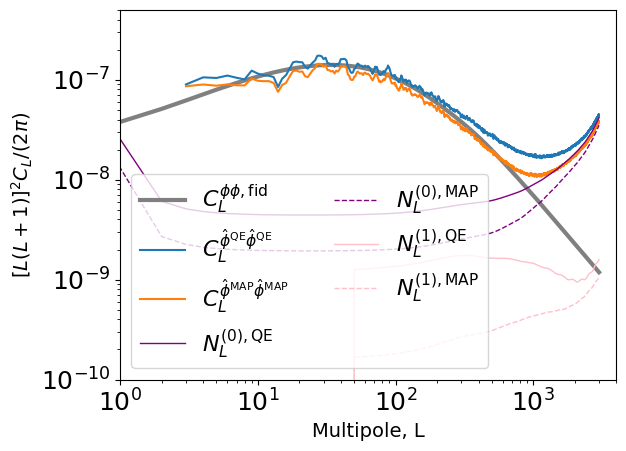

In [31]:
ana_mwe.cpp = ana_mwe.cls_unl['pp'][:3001]
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, [ana_mwe.itmax])[0]

ll = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

ana_mwe.WF_QE_cpp = (ana_mwe.cpp * dutils.cli(ana_mwe.cpp + N0_QE))**2
ana_mwe.WF_MAP_cpp = (ana_mwe.cpp * dutils.cli(ana_mwe.cpp + N0_MAP))**2

plt.plot(scale_factor*(ana_mwe.cpp), label=r'$C_L^{\phi\phi,{\rm fid}}$', color='grey', lw=3)
plt.plot(movavg(scale_factor*hp.alm2cl(plm_QE)/ana_mwe.WF_QE_cpp, 5), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(movavg(scale_factor*hp.alm2cl(plm_MAP)/ana_mwe.WF_MAP_cpp, 5), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')
plt.plot(scale_factor*N0_QE, label=r'$N_L^{(0),\rm{QE}}$', color='purple', lw=1)
plt.plot(scale_factor*N0_MAP, label=r'$N_L^{(0),\rm{MAP}}$', color='purple', lw=1, ls='--')
plt.plot(scale_factor*N1_QE, label=r'$N_L^{(1),\rm{QE}}$', color='pink', lw=1)
plt.plot(scale_factor*N1_MAP, label=r'$N_L^{(1),\rm{MAP}}$', color='pink', lw=1, ls='--')

plt.legend(fontsize=16, loc='lower left', ncol=2)
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2C_L/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,4e3)
plt.ylim(1e-10,5e-7)
plt.yscale('log')

The MAP lensing potential seems to be a bit off, and this is totally expected. The reason for it is that the analytic Wiener-filter we apply to the MAP estimate is only correct when the iterative approach has converged. Clearly, this is not the case after only 2 iterations in this tutorial. Please change the itmax parameter in the config-file to a higher number (8-10 should suffice), rerun the iterative lensing reconstruction job, and plot this again to convince yourself that it is now better in agreement. One iteration should take about 5-10 minutes, depending on your machine.

# Summary and next steps
This tutorial demonstrated the usage of delensalot in an idealized setting, and you obtained lensing potential estimates and residual lensing amplitudes on a masked sky and from simulation data generated upon runtime. Finally, you calculated your predictions by using the (iterative) reconstruction biases $N_L^{(0)}$ and $N_L^{(1)}$.

delensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * masked sky,
 * inhomogeneous noise,
 * data inclusive of foreground (residuals).

It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot) for more.